# 02. Neural Network classification with PyTorch

Classification is a problem of predicting whether something is one thing or another

## 1. Make a classification data and get it ready

In [49]:
import sklearn
from sklearn.datasets import make_circles

# Make 1000 samples
n_samples = 1000

# Create circles
X, y = make_circles(n_samples,
                    noise=.03,
                    random_state=42)

In [50]:
len(X), len(y)

(1000, 1000)

In [51]:
print(f"First 5 samples of X:\n {X[:5]}")
print(f"First 5 samples of y:\n {y[:5]}")

First 5 samples of X:
 [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 samples of y:
 [1 1 1 1 0]


In [52]:
# Make DataFrame of circle data
import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0],
                        "X2": X[:, 1],
                        "label": y})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


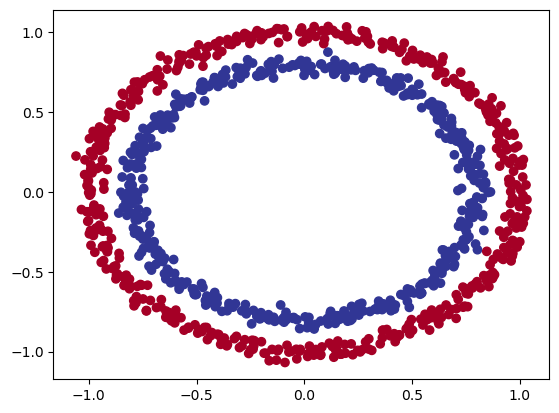

In [53]:
# Visualize, visualize, visualize
import matplotlib.pyplot as plt
plt.scatter(x=X[:,0],
            y=X[:,1],
            c=y,
            cmap=plt.cm.RdYlBu);

Note: The data we're working with is often referred to as a toy dataset, a dataset that is small enough to experiment on, but still sizable enough to practice the fundamentals.

### 1.1 Check input and output shapes

In [54]:
# View the first example of features and labels
X_sample = X[0]
y_sample = y[0]

print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")

Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shapes for one sample of X: (2,) and the same for y: ()


### 1.2 Turn data into tensors & create train and test splits

In [55]:
import torch
torch.__version__

'2.3.1'

In [56]:
# Turn data into tensors
X_tensor = torch.from_numpy(X).type(torch.float)
y_tensor = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(array([[ 0.75424625,  0.23148074],
        [-0.75615888,  0.15325888],
        [-0.81539193,  0.17328203],
        [-0.39373073,  0.69288277],
        [ 0.44220765, -0.89672343]]),
 array([1, 1, 1, 1, 0], dtype=int64))

In [57]:
type(X_tensor), X_tensor.dtype, y_tensor.dtype

(torch.Tensor, torch.float32, torch.float32)

In [58]:
# Split data into training and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_tensor,
                                                    y_tensor, 
                                                    test_size=0.2, #0.2 = 20% of data will be test, 80% will be training
                                                    random_state=42)
                                                    
len(X_train), len(X_test), len(y_train), len(y_test)


(800, 200, 800, 200)

## 2. Building a model

Let's build a model to classify our blue and red dots.

To do so, we want to:
1. Setup device agnostic code
2. Construct a model (by subclassing `nn.Module`)
3. Define a loss function & optimizer
4. Create a training and test loop

In [59]:
# import PyTorch and nn
import torch
from torch import nn
# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

Now we've setup device agnostic code, let's create a model that:

1. Subclasses `nn.Module` (almost all models in PyTorch subclass `nn.Module`)
2. Create 2 `nn.Linear` layers that are capable of handling the shapes of our data
3. Defines a `forward()` method that outlines the forward pass (or forward computation)
4. Instantiate an instance of our model class and send it to the target device

In [60]:
# 1. Construct a model that subclassing nn.Module

class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        # 2. Create two nn.Linear layers capable handling the shapes of our data
        self.layer_1 = nn.Linear(in_features=2, out_features=5) # takes 2 features (a single vector from X_train) and upscale to 5 features
        self.layer_2 = nn.Linear(in_features=5, out_features=1) # recieves the 5 features and outputs a single binary classification
    
    # 3. Overriding the forward() method
    def forward(self, x):
        return self.layer_2(self.layer_1(x)) # output of layer_1 with input x is input into layer_2
    
    # 4. Instantiate an instance of our model class and send to the target device
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [61]:
# the model above can be replicated with nn.Sequential()
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

In [62]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.0829, -0.2872],
                      [ 0.4691, -0.5582],
                      [-0.3260, -0.1997],
                      [-0.4252,  0.0667],
                      [-0.6984,  0.6386]])),
             ('0.bias', tensor([-0.6007,  0.5459,  0.1177, -0.2296,  0.4370])),
             ('1.weight',
              tensor([[ 0.0697,  0.3613,  0.0489, -0.1410,  0.1202]])),
             ('1.bias', tensor([-0.1213]))])

In [63]:
# Make predictions
with torch.inference_mode():
    untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(X_test)}, Shape: {X_test.shape}")
print(f"\nFirst 10 predictions:\n{torch.round(untrained_preds[:10])}")
print(f"\nFirst 10 labels:\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200, 2])

First 10 predictions:
tensor([[-0.],
        [-0.],
        [0.],
        [-0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [-0.]])

First 10 labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


### 2.1 Setup loss function and optimizer

Which loss function or optimizer should you use in a classification problem?

For regression, you might want MAE or MSE (mean absolute error or mean squared error).
For classification, you might want binary cross entropy or categorical cross entropy.

And for optimizers, two of the most common and useful are SGD and Adam, however, PyTorch has many built-in options.

* For the loss function, we're going to use `torch.nn.BCEWithLogitsLoss()`

In [64]:
# Setup the loss functions

loss_fn = torch.nn.BCEWithLogitsLoss() # BCEWithLogitsLoss = sigmoid activation function is built-in

optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

In [65]:
# Calculate accuracy - out of 100 examples, what percentage does our model get right?
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct/len(y_pred)) * 100
    return acc

## 3. Train model

To train the model, we need a training loop:

1. Forward pass
2. Calculate the loss
3. Optimizer zero grad
4. Loss backward (backpropagation)
5. Optimizer step (gradient descent)

### 3.1 Going from raw logits -> predictions probabilities -> prediction labels

Our model outputs are going to be raw **logits**

We can convert these **logits** into prediction probabilities by passing them to some kind of activation function (e.g. sigmoid for binary cross entropy and softmax for multiclass classification).

Then we can convert our model's prediction probabilities to **prediction labels** by either rounding them or taking the `argmax()`.

In [66]:
# View the first 5 outputs of the forward pass on the test data
with torch.inference_mode():
    y_logits = model_0(X_test.to(device))[:5]
y_logits # these are logits, the values output by the model before any sort of modification (activation function)

tensor([[-0.0338],
        [-0.0309],
        [ 0.0894],
        [-0.0692],
        [ 0.2967]])

In [67]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

The values of `y_logits` are obviously not the same as the values found in `y_test`, so we need to get it in the same format as `y_test`.

In [68]:
# Use the sigmoid activation function on our model logits to turn them into prediction probabilities
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.4916],
        [0.4923],
        [0.5223],
        [0.4827],
        [0.5736]])

For our prediction probability values, we need to perform a range-style rounding on them: 
* `y_pred_probs` >= 0.5, y=1 (class 1)
* `y_pred_probs` < 0.5, y=0 (class 0)

In [69]:
# Find the predicted labels

y_preds = torch.round(y_pred_probs)

# In full (logits -> pred probs -> pred labels)
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True])


tensor([0., 0., 1., 0., 1.])

### 3.2 Building a training and testing loop

In [70]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
epochs = 100

# Put the data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
    ### Training
    model_0.train()
    
    # 1. Forward pass
    y_logits = model_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labels
    
    # 2. Calculate loss/accuracy
    loss = loss_fn(y_logits, # nn.BCEWithLogitsLoss expects raw logits as input
                   y_train)
    acc = accuracy_fn(y_true=y_train, 
                      y_pred=y_pred)
    
    # 3. Optimizer zero grad
    optimizer.zero_grad()
    
    # 4. Loss backward (backpropagation)
    loss.backward()
    
    # 5. Optimizer step (gradient descent)
    optimizer.step()
    
    ### Testing
    model_0.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
 
        # 2. Calculate test loss/acc
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)
        
    # Print out what's happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69796, Acc: 51.88 | Test loss: 0.69440, Test acc: 58.00%
Epoch: 10 | Loss: 0.69590, Acc: 51.25 | Test loss: 0.69305, Test acc: 53.00%
Epoch: 20 | Loss: 0.69490, Acc: 51.62 | Test loss: 0.69254, Test acc: 49.50%
Epoch: 30 | Loss: 0.69435, Acc: 51.12 | Test loss: 0.69236, Test acc: 49.50%
Epoch: 40 | Loss: 0.69401, Acc: 50.88 | Test loss: 0.69232, Test acc: 51.00%
Epoch: 50 | Loss: 0.69378, Acc: 50.25 | Test loss: 0.69234, Test acc: 50.00%
Epoch: 60 | Loss: 0.69362, Acc: 50.00 | Test loss: 0.69239, Test acc: 51.50%
Epoch: 70 | Loss: 0.69351, Acc: 50.25 | Test loss: 0.69246, Test acc: 51.00%
Epoch: 80 | Loss: 0.69342, Acc: 49.88 | Test loss: 0.69254, Test acc: 50.00%
Epoch: 90 | Loss: 0.69336, Acc: 49.88 | Test loss: 0.69262, Test acc: 53.00%


## 4. Make predictions and evaluate the model

From the metrics, it looks like our model isn't learning anything...

To visualize, we're going to import a function called `plot_decison_boundary()`

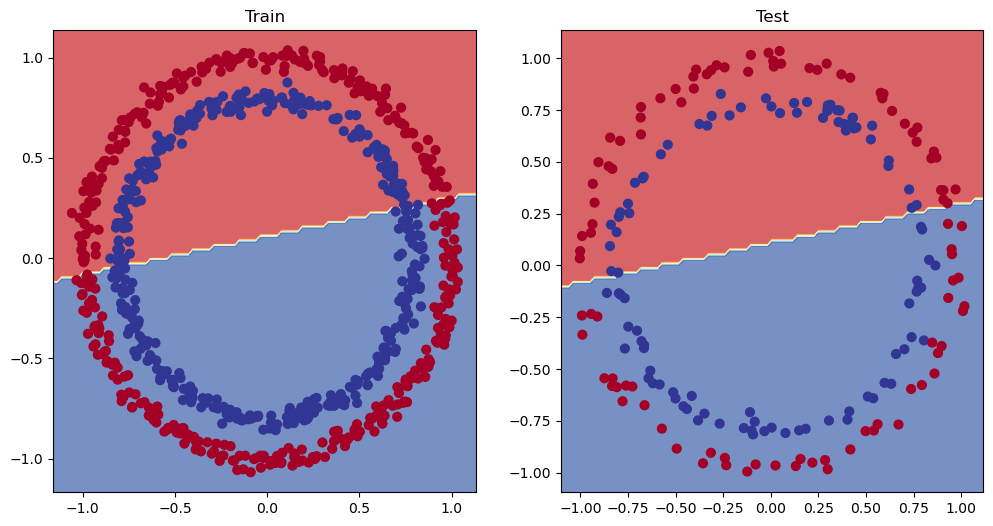

In [71]:
from helper_functions import plot_decision_boundary, plot_predictions

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)



## 5. Improving a model (from a model perspective)

* Add more layers - give the model more chances to learn about patterns in the data
* Add more hidden units - go from 5 hidden units to 10 hidden units
* Fit for longer - more epochs
* Changing the activation functions
* Change the learning rate
* Changing the loss function

These options are all values we can change, they are referred to as hyperparameters.

Let's try and improve the model by:
* Adding more hidden units 5 -> 10
* Increase the number of layers: 2 -> 3
* Increase the number of epochs: 100 -> 1000

In [72]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        
    def forward(self, x):
        return self.layer_3(self.layer_2(self.layer_1(x)))

model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [73]:
# Create a loss function
loss_fn = nn.BCEWithLogitsLoss()

# Create an optimizer
optimizer = torch.optim.SGD(model_1.parameters(),
                            lr=0.1)

In [74]:
# Write a training and evaluation loop for model_1
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Train for longer
epochs = 1000

# Put data on the target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    model_1.train()
    
    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))
    
    loss = loss_fn(y_logits,
                   y_train)
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)
    
    optimizer.zero_grad()
    
    loss.backward()
    
    optimizer.step()
    
    model_1.eval()
    
    with torch.inference_mode():
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)
    
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f} | Acc: {acc:.2f} | Test Loss: {test_loss:.5f} | Test Acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 0.69396 | Acc: 50.88 | Test Loss: 0.69261 | Test Acc: 51.00%
Epoch: 100 | Loss: 0.69305 | Acc: 50.38 | Test Loss: 0.69379 | Test Acc: 48.00%
Epoch: 200 | Loss: 0.69299 | Acc: 51.12 | Test Loss: 0.69437 | Test Acc: 46.00%
Epoch: 300 | Loss: 0.69298 | Acc: 51.62 | Test Loss: 0.69458 | Test Acc: 45.00%
Epoch: 400 | Loss: 0.69298 | Acc: 51.12 | Test Loss: 0.69465 | Test Acc: 46.00%
Epoch: 500 | Loss: 0.69298 | Acc: 51.00 | Test Loss: 0.69467 | Test Acc: 46.00%
Epoch: 600 | Loss: 0.69298 | Acc: 51.00 | Test Loss: 0.69468 | Test Acc: 46.00%
Epoch: 700 | Loss: 0.69298 | Acc: 51.00 | Test Loss: 0.69468 | Test Acc: 46.00%
Epoch: 800 | Loss: 0.69298 | Acc: 51.00 | Test Loss: 0.69468 | Test Acc: 46.00%
Epoch: 900 | Loss: 0.69298 | Acc: 51.00 | Test Loss: 0.69468 | Test Acc: 46.00%


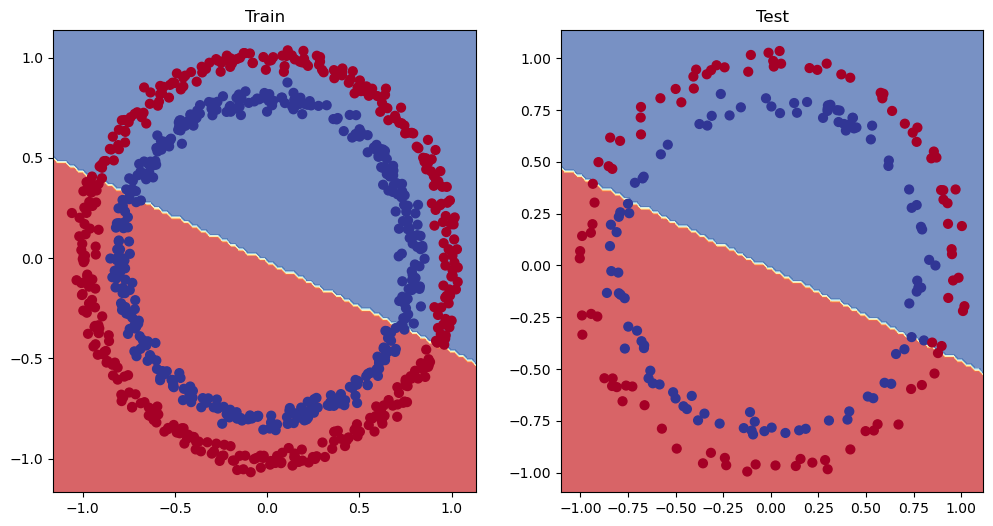

In [75]:
# Plot the decision boundary
plt.figure(figsize=(12,6))
plt.subplot(1,2,1) 
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

### 5.1 Preparing data to see if our model can fit a straight line

One way to troubleshoot to a larger problem is to test out a smaller problem

In [76]:
# Create some data (same as notebook 01)
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

# Create data
X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias # linear regression formula

# Check the data
print(len(X_regression))
X_regression[:5], y_regression[:5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [77]:
# Create train and test splits
train_split = int(0.8 * len(X_regression))
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]

len(y_train_regression), len(y_test_regression)

(80, 20)

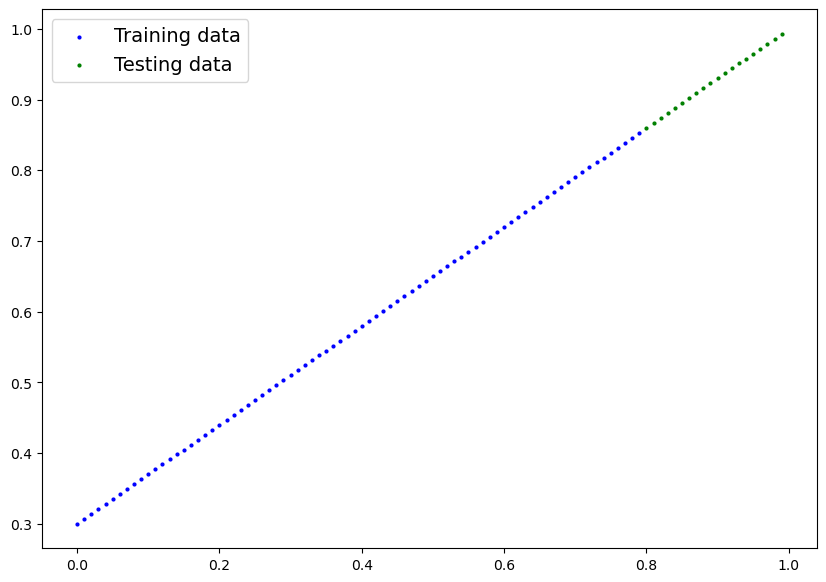

In [78]:
plot_predictions(train_data=X_train_regression,
                 train_labels=y_train_regression,
                 test_data=X_test_regression,
                 test_labels=y_test_regression)

### 5.2 Adjusting `model_1` to fit a straight line

In [79]:
# Same architecture as model_1 (but using nn.Sequential())
model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)

model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [89]:
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(model_2.parameters(),
                            lr=0.01)

In [90]:
# Train the model
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1000

X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

# Training
for epoch in range(epochs):
    model_2.train()
    
    y_pred = model_2(X_train_regression)
    loss = loss_fn(y_pred, y_train_regression)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Testing
    model_2.eval()
    with torch.inference_mode():
        test_pred = model_2(X_test_regression)
        test_loss = loss_fn(test_pred, y_test_regression)
        
    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f} | Test Loss: {test_loss:.5f}")

Epoch: 0 | Loss: 0.05214 | Test Loss: 0.08671
Epoch: 100 | Loss: 0.00341 | Test Loss: 0.00406
Epoch: 200 | Loss: 0.00540 | Test Loss: 0.00058
Epoch: 300 | Loss: 0.00596 | Test Loss: 0.00120
Epoch: 400 | Loss: 0.00568 | Test Loss: 0.00081
Epoch: 500 | Loss: 0.00568 | Test Loss: 0.00085
Epoch: 600 | Loss: 0.00596 | Test Loss: 0.00153
Epoch: 700 | Loss: 0.00568 | Test Loss: 0.00105
Epoch: 800 | Loss: 0.00596 | Test Loss: 0.00111
Epoch: 900 | Loss: 0.00568 | Test Loss: 0.00075


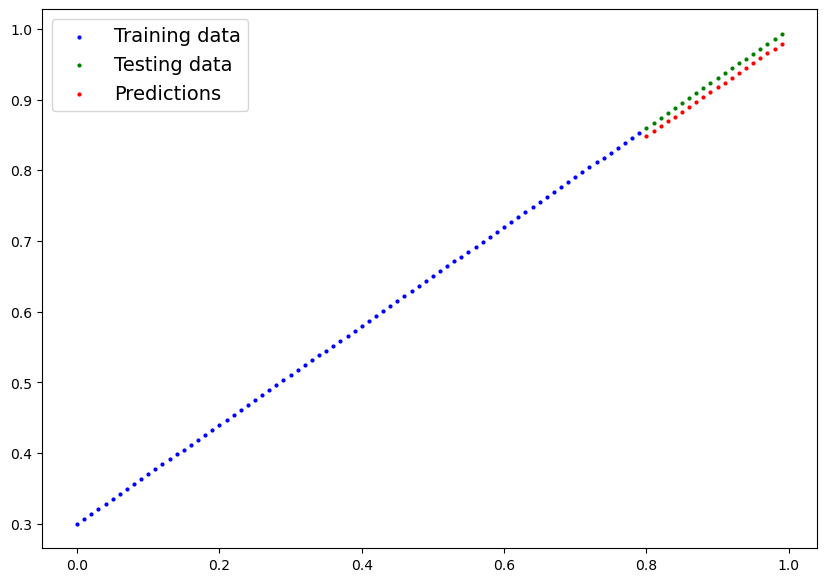

In [92]:
model_2.eval()
with torch.inference_mode():
    y_preds = model_2(X_test_regression)
    
plot_predictions(train_data=X_train_regression.cpu(), 
                 train_labels=y_train_regression.cpu(),
                 test_data=X_test_regression.cpu(),
                 test_labels=y_test_regression.cpu(),
                 predictions=y_preds.cpu())

## 6. The missing piece: non-linearity

"What patterns could you draw if you were given an infinite amount of straight and non-straight lines?"

### 6.1 Recreating non-linear data (red and blue circles)

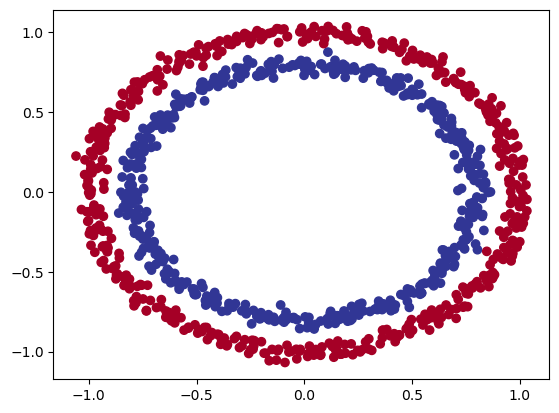

In [105]:
# Make and plot data
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples, noise=0.03, random_state=42)

plt.scatter(X[:,0], X[:, 1], c=y, cmap=plt.cm.RdYlBu)

In [106]:
# Conver data to tensors and then to train and test splits
import torch
from sklearn.model_selection import train_test_split

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 6.2 Building a model with non-linearity

In [108]:
# Build a model with non-linear activation functions
from torch import nn

class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))
        
model_3 = CircleModelV2().to(device)
model_3

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)